<a href="https://colab.research.google.com/github/dave502/NLP/blob/main/lesson_05/nlp_hw_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pyconll
!pip install deeppavlov
!python -m deeppavlov install ner_ontonotes_bert_torch
!pip install pymorphy2

In [ ]:
%%capture
!pip install corus
!pip install razdel

In [ ]:
# !pip uninstall scikit-learn -y
# !pip install -U scikit-learn

In [ ]:
# !pip install -U tensorflow

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import brown
from nltk.tag import DefaultTagger, UnigramTagger, BigramTagger, TrigramTagger, RegexpTagger
import pyconll

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import deeppavlov
from deeppavlov import configs, build_model

from pymorphy2 import MorphAnalyzer

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn import model_selection, preprocessing, linear_model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, GRU, LSTM, Dropout, Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from corus import load_ne5
from razdel import tokenize
import pandas as pd
import numpy as np


**Проверка работы UnigramTagger, BigramTagger, TrigramTagger**

In [ ]:
# загрузка даных
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [ ]:
tags = [tag for (word, tag) in brown.tagged_words(categories='news')]
nltk.FreqDist(tags)

FreqDist({'NN': 13162, 'IN': 10616, 'AT': 8893, 'NP': 6866, ',': 5133, 'NNS': 5066, '.': 4452, 'JJ': 4392, 'CC': 2664, 'VBD': 2524, ...})

In [ ]:
brown_tagged_sents = brown.tagged_sents()
train_len = int(len(brown_tagged_sents)*0.9)
train_data, test_data = brown_tagged_sents[:train_len], brown_tagged_sents[train_len:]
test_sent = brown.sents()[0]

In [ ]:
# инициализация тэггеров
unigram_tagger = UnigramTagger(train_data)
bigram_tagger = BigramTagger(train_data, backoff=unigram_tagger)
trigram_tagger = BigramTagger(train_data, backoff=bigram_tagger)

In [ ]:
# вывод результатов работы тэггеров и метрик в табличном виде
pd.DataFrame(zip([x[0] for x in unigram_tagger.tag(test_sent)],\
         [x[1] for x in unigram_tagger.tag(test_sent)],\
         [x[1] for x in bigram_tagger.tag(test_sent)],\
         [x[1] for x in trigram_tagger.tag(test_sent)])).\
         append(pd.DataFrame({'accuracy': [' ',
                 f'{unigram_tagger.accuracy(test_data):5f}',\
                 f'{bigram_tagger.accuracy(test_data):5f}',\
                 f'{trigram_tagger.accuracy(test_data):5f}']}).transpose())

,0,1,2,3
0,The,AT,AT,AT
1,Fulton,NP-TL,NP-TL,NP-TL
2,County,NN-TL,NN-TL,NN-TL
3,Grand,JJ-TL,JJ-TL,JJ-TL
4,Jury,NN-TL,NN-TL,NN-TL
5,said,VBD,VBD,VBD
6,Friday,NR,NR,NR
7,an,AT,AT,AT
8,investigation,NN,NN,NN
9,of,IN,IN,IN


В данном случае биграмные и триграмные тэгеры показали себя немного лучше униграмных

**Тэггер с использованием классификатора**

In [ ]:
# загрузка данных
!wget -O train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-Taiga/master/ru_taiga-ud-train.conllu -nv
!wget -O test.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-Taiga/master/ru_taiga-ud-dev.conllu -nv

2022-10-25 08:54:57 URL:https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-Taiga/master/ru_taiga-ud-train.conllu [17229332/17229332] -> "train.conllu" [1]
2022-10-25 08:54:57 URL:https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-Taiga/master/ru_taiga-ud-dev.conllu [910013/910013] -> "test.conllu" [1]


In [ ]:
full_train = pyconll.load_from_file('train.conllu')
full_test  = pyconll.load_from_file('test.conllu')

In [ ]:
all_train_texts = [' '.join(token.form for token in sent) for sent in full_train]
all_train_texts[:5]

['Снова приобрел дозу ,',
 'В женщине важна верность , а не красота .',
 'Важно то , о чем ты думаешь и какие поступки совершаешь .',
 'Уже не та на лоб спадает челка ...',
 'Но ты не живешь по-евангельски , и это — причина твоих проблем .']

In [ ]:
fdata_train = []
for sent in full_train[:]:
    fdata_train.append([(token.form, token.upos) for token in sent])
    
fdata_test = []
for sent in full_test[:]:
    fdata_test.append([(token.form, token.upos) for token in sent])
    
fdata_sent_test = []
for sent in full_test[:]:
    fdata_sent_test.append([token.form for token in sent])

In [ ]:
fdata_train[0]

[('Снова', 'ADV'), ('приобрел', 'VERB'), ('дозу', 'NOUN'), (',', 'PUNCT')]

In [ ]:
# проверка работы биграмного тэгера
bigram_tagger = BigramTagger(fdata_train, backoff=UnigramTagger(fdata_train))
display(bigram_tagger.tag(fdata_sent_test[100]), bigram_tagger.accuracy(fdata_test))

[('Не', 'PART'), ('могу', 'VERB'), ('найти', 'VERB'), ('воробья', None)]

0.6859152139461173

In [ ]:
# создание списка токенов и списка тэгов
train_tok = []
train_label = []
for sent in fdata_train[:]:
    for tok in sent:
        train_tok.append(tok[0])
        train_label.append('NO_TAG' if tok[1] is None else tok[1])
        
test_tok = []
test_label = []
for sent in fdata_test[:]:
    for tok in sent:
        test_tok.append(tok[0])
        test_label.append('NO_TAG' if tok[1] is None else tok[1])

In [ ]:
# энкодинг тэгов
le = LabelEncoder()
train_enc_labels = le.fit_transform(train_label)
test_enc_labels = le.transform(test_label)

In [ ]:
# инициализация векторайзеров по символам
cv_vectorizer_char = CountVectorizer(ngram_range=(1, 3), analyzer='char', max_features=100)
tfidf_vectorizer_char = TfidfVectorizer(ngram_range=(1, 3), analyzer='char', max_features=100)
hv_ectorizer_char = HashingVectorizer(ngram_range=(1, 3), analyzer='char', n_features=100)
# инициализация векторайзеров по словам
cv_vectorizer_word = CountVectorizer(ngram_range=(1, 3), analyzer='word', max_features=100)
tfidf_vectorizer_word = TfidfVectorizer(ngram_range=(1, 3), analyzer='word', max_features=100)
hv_ectorizer_word = HashingVectorizer(ngram_range=(1, 3), analyzer='word', n_features=100)

vectorizers = {'cv_vectorizer_char':cv_vectorizer_char,
               'tfidf_vectorizer_char':tfidf_vectorizer_char,
               'hv_ectorizer_char':hv_ectorizer_char,
               'cv_vectorizer_word':cv_vectorizer_word,
               'tfidf_vectorizer_word':tfidf_vectorizer_word,
               'hv_ectorizer_word':hv_ectorizer_word}

In [ ]:
# проверка векорайзеров на тестовых данных и вывод метрик
results = pd.DataFrame(columns=['vectorizer', 'accuracy'])
for i, (name, vectorizer) in enumerate(vectorizers.items()):
  X_train = vectorizer.fit_transform(train_tok)
  X_test  = vectorizer.transform(test_tok)

  clf = LogisticRegression(random_state=42, max_iter=20)
  clf.fit(X_train, train_enc_labels)
  pred = clf.predict(X_test)
  accuracy = accuracy_score(test_enc_labels, pred)
  results.loc[i] = [name, accuracy]

results

,vectorizer,accuracy
0,cv_vectorizer_char,0.651743
1,tfidf_vectorizer_char,0.640055
2,hv_ectorizer_char,0.587956
3,cv_vectorizer_word,0.394017
4,tfidf_vectorizer_word,0.394017
5,hv_ectorizer_word,0.272682


Классификация с использованием векторайзеров и логистической регрессии в данном примере не дало преимуществ по сревнению с биграмным тэгером. Использование CountVectorizer и  TfidfVectorizer с векторизацией по символам показало значительно лучшие результаты остальных вариантов.

**Проверка deeppavlov**

In [ ]:
# инициализация модели
deeppavlov_ner = build_model(configs.ner.ner_ontonotes_bert_torch, download=True)

In [ ]:
# загрузка данных
!wget http://www.labinform.ru/pub/named_entities/collection5.zip -O temp.zip
!unzip temp.zip
!rm temp.zip

In [ ]:
# чтение произвольного файла
with open('Collection5/uchitel.txt', 'r') as file:
  text = file.read().replace('\n', ' ')

In [ ]:
text

'Вице-мэром Новосибирска по социальным вопросам стал учитель 10:14 31.01.2013  Мэр Новосибирска Владимир Городецкий назначил своим заместителем по социальным вопросам бывшего замначальника городского управления образования Сергея Нелюбова; главным финансистом города стал бывший первый замглавы Бердска Владимир Штоп.'

In [ ]:
# получение и отображение результата
result = deeppavlov_ner([text])

In [ ]:
pd.DataFrame(zip(result[0][0], result[1][0])).style.applymap(
           lambda x: 'color: red' if x != 'O' else 'color: black', subset=pd.IndexSlice[:,1:])

,0,1
0,Вице,O
1,-,O
2,мэром,O
3,Новосибирска,O
4,по,O
5,социальным,O
6,вопросам,O
7,стал,O
8,учитель,O
9,10,B-TIME


**NER с использованием NN**

In [ ]:
# загрузка данных
!wget http://www.labinform.ru/pub/named_entities/collection5.zip -O temp.zip
!unzip temp.zip
!rm temp.zip

In [ ]:
records = load_ne5('/content/Collection5')
next(records)

Ne5Markup(
    id='047',
    text='Обама выбрал главную защитницу американских потребителей\r\n\r\nПрезидент Барак Обама выбрал назначенца на должность председателя Комиссии США по безопасности потребительской продукции (CPSC), сообщило агентство Reuters. Этот пост достанется Инес Мур Тененбаум (Inez Moore Tenenbaum) - бывшему инспектору учебных заведений из Южной Каролины. Кроме того, Обама планирует увеличить число членов Комиссии.\r\n\r\nИнес Тененбаум дважды, в 1998 и 2002 годах, избиралась от демократов на пост главного инспектора учебных заведений штата Южная Каролина. После победы Обамы на выборах ее называли вероятным претендентом на пост министра образования в новой администрации. О ее грядущем назначении руководителем CPSC Белый дом объявил во вторник.\r\n\r\nПо плану Обамы, число членов CPSC должно вырасти с трех до пяти. Одним из новых членов Комиссии предполагается назначить Роберта Адлера (Robert Adler), профессора Университета Северной Каролины, занимающийся вопросами по

In [ ]:
words_docs = []
for ix, rec in enumerate(records):
    words = []
    for token in tokenize(rec.text):
        type_ent = 'OUT'
        for ent in rec.spans:
            if (token.start >= ent.start) and (token.stop <= ent.stop):
                type_ent = ent.type
                break
        words.append([token.text, type_ent])
    words_docs.extend(words)

In [ ]:
df_words = pd.DataFrame(words_docs, columns=['word', 'tag'])
df_words['tag'].value_counts()

OUT         218460
PER          21102
ORG          13615
LOC           4559
GEOPOLIT      4345
MEDIA         2480
Name: tag, dtype: int64

In [ ]:
df_words.sample(3)

,word,tag
148095,самолетом,OUT
220389,кафедры,OUT
198525,период,OUT


In [ ]:
# разбиение данных
train_x, test_x, train_y, test_y = model_selection.train_test_split(df_words['word'], df_words['tag'], test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train_x, train_y, test_size=0.25, random_state=42)

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
test_y  = encoder.fit_transform(test_y)

In [ ]:
# преобразование в тензоры
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))

valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

test_data  = tf.data.Dataset.from_tensor_slices(test_x)

train_data = train_data.batch(16)
valid_data = valid_data.batch(16)
test_data  = test_data.batch(16)

AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data  = test_data.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# слой векторизации
def custom_standardization(input_data):
    return input_data

vocab_size = 30000
seq_len = 10

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    #ngrams=(1, 3),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [ ]:
# модель
class modelNER(tf.keras.Model):

    def __init__(self, embedding_dim = 64):
        super(modelNER, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim)
        self.gPool = GlobalMaxPooling1D()
        self.fc1 = Dense(300, activation='relu')
        self.fc2 = Dense(50, activation='relu')
        self.fc3 = Dense(6, activation='softmax')

    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        pool_x = self.gPool(x)
        
        fc_x = self.fc1(pool_x)
        fc_x = self.fc2(fc_x)
        
        concat_x = tf.concat([pool_x, fc_x], axis=1)
        prob = self.fc3(concat_x)
        return prob

In [ ]:
mmodel = modelNER()
mmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# обучение
mmodel.fit(train_data, validation_data=valid_data, epochs=10)

Epoch 1/10
9921/9921 [==============================] - 49s 5ms/step - loss: 0.3192 - accuracy: 0.9069 - val_loss: 0.2223 - val_accuracy: 0.9348
Epoch 2/10
9921/9921 [==============================] - 48s 5ms/step - loss: 0.1305 - accuracy: 0.9615 - val_loss: 0.2448 - val_accuracy: 0.8835
Epoch 3/10
9921/9921 [==============================] - 46s 5ms/step - loss: 0.1094 - accuracy: 0.9657 - val_loss: 0.2223 - val_accuracy: 0.9388
Epoch 4/10
9921/9921 [==============================] - 48s 5ms/step - loss: 0.1028 - accuracy: 0.9668 - val_loss: 0.2559 - val_accuracy: 0.8834
Epoch 5/10
9921/9921 [==============================] - 52s 5ms/step - loss: 0.0995 - accuracy: 0.9674 - val_loss: 0.2760 - val_accuracy: 0.8835
Epoch 6/10
9921/9921 [==============================] - 49s 5ms/step - loss: 0.0975 - accuracy: 0.9679 - val_loss: 0.2647 - val_accuracy: 0.8827
Epoch 7/10
9921/9921 [==============================] - 53s 5ms/step - loss: 0.0960 - accuracy: 0.9681 - val_loss: 0.2586 - val_ac

In [ ]:
# предикт
pred = mmodel.predict(test_data)

3308/3308 [==============================] - 6s 2ms/step


f1_score for NER = [('GEOPOLIT', 0.8890207715133531), ('LOC', 0.7979924717691342), ('MEDIA', 0.8386388583973655), ('ORG', 0.6414651326602487), ('OUT', 0.9648817378383473), ('PER', 0.8076709282934965)]
f1_score общий = 0.9309745938267845


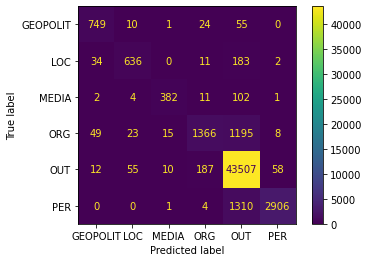

In [ ]:
# метрики
pred_max = np.argmax(pred, axis=1)
matrix = confusion_matrix(test_y, pred_max)
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels=encoder.classes_) 
cm_display.plot()
print(f'f1_score for NER = {list(zip(encoder.classes_, f1_score(test_y, pred_max, average=None)))}')
print(f'f1_score общий = {f1_score(test_y, pred_max, average="weighted")}')

Результаты хорошие, лучше всего определяются тэги OUT и GEOPOLIT, теги ORG определяются хуже, почти половина уходит в OUT.

*Сетка с соседними токенами не заработала.*